# Use Keras pre-trained VGG16

In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.set_random_seed(1234)

In [2]:
target_width = 224
target_height = 224
delta = 16

## Read train data and validation data ##

In [3]:
from dataset import read_train
images, labels = read_train('ProcessedTrainingData/', (target_width, target_height, 3), 'labels.npy')

In [4]:
def rgb_to_gray(images):
    from skimage.color import rgb2gray
    
    result = np.empty((images.shape[0], target_width, target_height, 1))
    for i in range(images.shape[0]):
        result[i, :, :, 0] = rgb2gray(images[i])
    return result

images = rgb_to_gray(images)

In [5]:
images.shape

(2896, 224, 224, 1)

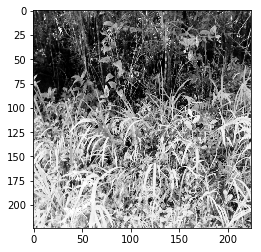

In [6]:
import matplotlib.pyplot as plt
plt.imshow(images[0, :, :, 0], cmap='gray')
plt.show()

# Shuffle input

In [7]:
def shuffle(images, labels):
    random_index = np.random.permutation(labels.size)
    return images[random_index], labels[random_index]

In [8]:
images, labels = shuffle(images, labels)

# Split train data and validation data

In [9]:
val_split_num = int(round(0.2 * labels.size))
images_train = images[val_split_num:]
labels_train = labels[val_split_num:]
images_val = images[:val_split_num]
labels_val = labels[:val_split_num]

print('images_train', images_train.shape)
print('labels_train', labels_train.shape)
print('images_val', images_val.shape)
print('labels_val', labels_val.shape)

images_train (2317, 224, 224, 1)
labels_train (2317,)
images_val (579, 224, 224, 1)
labels_val (579,)


# Use Keras pre-trained VGG16

In [13]:
def build_model():
    from keras.models import Sequential
    from keras import optimizers
    from keras import layers
    from keras import initializers
    
    model = Sequential()

    model.add(layers.Conv2D(96, kernel_size=(5, 5),
                     input_shape=(target_width, target_height, 1),
                     kernel_initializer=initializers.glorot_normal(),
                     bias_initializer=initializers.glorot_uniform(),
                     padding='same',
                     name='conv_1'))
    model.add(layers.BatchNormalization(name='batch_norm_1'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool1'))

    model.add(layers.Conv2D(256, (5, 5),
                     kernel_initializer=initializers.glorot_normal(),
                     bias_initializer=initializers.glorot_uniform(),
                     padding='same', name='conv_2'))
    model.add(layers.BatchNormalization(name='batch_norm_2'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool2'))

    model.add(layers.Conv2D(384, (3, 3),
                     kernel_initializer=initializers.glorot_normal(),
                     bias_initializer=initializers.glorot_uniform(),
                     padding='same', name='conv_3'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization(name='batch_norm_3'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool_3'))

    model.add(layers.Conv2D(512, (3, 3),
                     kernel_initializer=initializers.glorot_normal(),
                     bias_initializer=initializers.glorot_uniform(),
                     padding='same', name='conv_4'))
    model.add(layers.BatchNormalization(name='batch_norm_4'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pool_4'))

    model.add(layers.Flatten(name='flatten1'))
    model.add(layers.Dense(256, activation='relu',
                    kernel_initializer='uniform',
                    bias_initializer='uniform',
                    name='dense_1'))
    model.add(layers.Dropout(0.5, name='dropout_1'))
    model.add(layers.Dense(1, activation='sigmoid',
                    kernel_initializer='uniform',
                    bias_initializer='uniform',
                    name='output'))

    optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
    
    return model

In [14]:
def train():
    from keras.preprocessing.image import ImageDataGenerator
    from keras.callbacks import ModelCheckpoint
    from keras.callbacks import ReduceLROnPlateau
    from keras import backend as K
    
    K.clear_session()
    
    model = build_model()
    
    # TODO Change to 32 when training real network
    batch_size = 32
    # TODO Change to 50 when training real network
    epochs = 50

    train_datagen = ImageDataGenerator(
                    rotation_range=30, 
                    width_shift_range=0.1,
                    height_shift_range=0.1)
    train_datagen.fit(images_train)

    val_datagen = ImageDataGenerator()
    val_datagen.fit(images_val)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=2,
                                    verbose=1, 
                                    mode='auto',
                                    epsilon=0.0001,
                                    cooldown=0, min_lr=1e-6)

    checkpointer = ModelCheckpoint('ConvNet.model', monitor='val_acc', save_best_only=True)
    
    history = model.fit_generator(
        train_datagen.flow(images_train, labels_train, batch_size=batch_size, shuffle=True),
        steps_per_epoch=images_train.shape[0] // batch_size,
        epochs=epochs,
        validation_data=val_datagen.flow(images_val, labels_val, batch_size=1),
        validation_steps=labels_val.size,
        callbacks=[checkpointer, reduce_lr]
    )
    
    return history, model

# Training itself

In [ ]:
history, model = train()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 96)      2496      
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 224, 224, 96)      384       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 96)      0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 112, 112, 96)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 256)     614656    
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 112, 112, 256)     1024      
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 256)     0         
__________

In [ ]:
from keras import models

model = models.load_model('ConvNet.model')
model.trainable = False
for layer in model.layers:
    layer.trainable = False

In [ ]:
train_predictions = model.predict(images, verbose=1).flatten()

In [ ]:
from sklearn.metrics import accuracy_score

print('ConvNet train accuracy')
accuracy_score(labels, np.round(train_predictions))